## LSTM Model Experimentation

In [30]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

### Additional Pre-processing steps

In [18]:
# load in datasets from `feature_analysis.ipynb`
# y values are mapped

x_train = pd.read_csv('data/x_train_scaled.csv')
x_test = pd.read_csv('data/x_test_scaled.csv')
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')

# convert all x to numpy arrays
x_train = x_train.values if hasattr(x_train, "values") else x_train
x_test = x_test.values if hasattr(x_test, "values") else x_test

In [19]:
# reshaping x for (samples, timesteps, features)
# shape: (samples, 1, features)
# leaving timestep as 1 since data does not contain sequential time-series values
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

print(x_train.shape)
print(x_test.shape)


(480, 1, 20)
(179, 1, 20)


## LSTM Model Experimentation 

### Experiments with label mapping

In [20]:
model_LM = Sequential()

# First LSTM layer
model_LM.add(LSTM(units=128, input_shape=(1, 20), return_sequences=False))  # (timesteps=1, features=20)
model_LM.add(BatchNormalization())
model_LM.add(Dropout(0.3))

# Fully connected layer
model_LM.add(Dense(64, activation='relu'))
model_LM.add(Dropout(0.3))

# Output layer
model_LM.add(Dense(4, activation='softmax'))

# Compile the model
model_LM.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', # best for label mapped values
    metrics=['accuracy']
)

# Print summary
model_LM.summary()

/usr/local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │        76,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,316 (333.27 KB)

 Trainable params: 85,060 (332.27 KB)

 Non-trainable params: 256 (1.00 KB)

In [21]:
history = model_LM.fit(
    x_train,
    y_train,  # integer-encoded labels
    validation_data=(x_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=0
)

In [22]:
y_pred_probs = model_LM.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step


In [26]:
# Basic metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.888268156424581
Precision: 0.8943478619456272
Recall: 0.888268156424581
F1 Score: 0.8875688552869384


In [28]:
print("\nClassification Matrix:\n")
print(classification_report(y_test, y_pred, target_names=['Bach', 'Beethoven', 'Chopin', 'Mozart']))


Classification Matrix:

              precision    recall  f1-score   support

        Bach       0.93      0.98      0.95        52
   Beethoven       0.79      0.93      0.85        44
      Chopin       0.96      0.84      0.90        51
      Mozart       0.89      0.75      0.81        32

    accuracy                           0.89       179
   macro avg       0.89      0.88      0.88       179
weighted avg       0.89      0.89      0.89       179



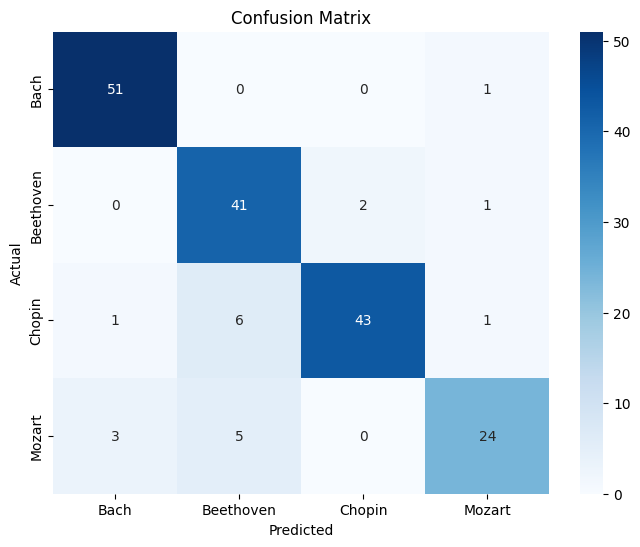

In [29]:
cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bach', 'Beethoven', 'Chopin', 'Mozart'],
            yticklabels=['Bach', 'Beethoven', 'Chopin', 'Mozart'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Experiments with One-Hot Encoding

In [33]:
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

print(y_train_onehot.shape)  # (num_samples, num_classes)
print(y_test_onehot.shape)


(480, 4)
(179, 4)


In [34]:
model_cat = Sequential()

model_cat.add(LSTM(128, input_shape=(4, 20), return_sequences=False))
model_cat.add(BatchNormalization())
model_cat.add(Dropout(0.3))

model_cat.add(Dense(64, activation='relu'))
model_cat.add(Dropout(0.3))

model_cat.add(Dense(4, activation='softmax'))

model_cat.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_cat.summary()


/usr/local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 128)            │        76,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,316 (333.27 KB)

 Trainable params: 85,060 (332.27 KB)

 Non-trainable params: 256 (1.00 KB)

In [36]:
model_cat.fit(
    x_train,
    y_train_onehot,
    validation_data=(x_test, y_test_onehot),
    epochs=30,
    batch_size=32,
    verbose=0
)

In [37]:
y_pred_probs = model_cat.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


In [38]:
# Basic metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.9608938547486033
Precision: 0.9612718790485699
Recall: 0.9608938547486033
F1 Score: 0.9607997111081522


In [39]:
print("\nClassification Matrix:\n")
print(classification_report(y_test, y_pred, target_names=['Bach', 'Beethoven', 'Chopin', 'Mozart']))


Classification Matrix:

              precision    recall  f1-score   support

        Bach       0.96      1.00      0.98        52
   Beethoven       0.93      0.95      0.94        44
      Chopin       0.98      0.94      0.96        51
      Mozart       0.97      0.94      0.95        32

    accuracy                           0.96       179
   macro avg       0.96      0.96      0.96       179
weighted avg       0.96      0.96      0.96       179



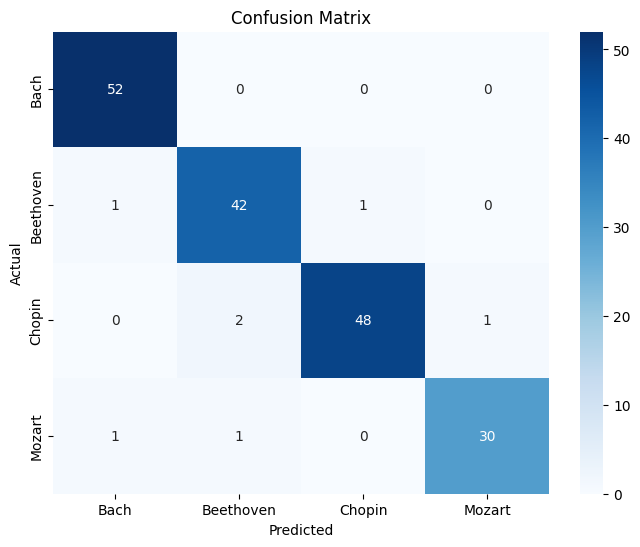

In [40]:
cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bach', 'Beethoven', 'Chopin', 'Mozart'],
            yticklabels=['Bach', 'Beethoven', 'Chopin', 'Mozart'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()